### What We’re Doing in Notebook 3: Astronomical Event Correlation
### 🛸 Hypothesis:
UFO sightings might increase on dates with known astronomical phenomena, like meteor showers or eclipses.

### ✅ Current Implementation:
1. Load UFO sightings and group by day.

2. Load astronomical events (e.g., meteor showers) with their exact dates.

3. Flag each day as:

astro_event = True if there's a known event that day

False otherwise

4. Compare sightings between those two groups:

Boxplot

Mean/median comparison


In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the UFO dataset
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/UFO/scrubbed_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df = df.dropna(subset=['datetime'])
df.head()

Mounted at /content/drive


<ipython-input-1-18da18c9914b>:8: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/UFO/scrubbed_data.csv')


,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,1956-10-10 21:00:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [9]:
# # Load astronomical events data (e.g., meteor showers)
# # Assumes file is already uploaded to Drive manually
# astro_df = pd.read_csv('/content/drive/MyDrive/UFO/meteor_showers.csv')
# astro_df['date'] = pd.to_datetime(astro_df['date'], errors='coerce')
# astro_df = astro_df.dropna(subset=['date'])
# astro_df.head()

In [10]:
# Create recurring meteor shower dates from 1900 to 2024
shower_days = {
    'Quadrantids': '01-03',
    'Lyrids': '04-22',
    'Eta Aquariids': '05-06',
    'Delta Aquariids': '07-30',
    'Perseids': '08-12',
    'Orionids': '10-21',
    'Leonids': '11-17',
    'Geminids': '12-14',
    'Ursids': '12-22'
}

# Generate dates for all years in the dataset
years = pd.date_range(df['datetime'].min(), df['datetime'].max(), freq='Y').year
meteor_dates = []
for year in years:
    for name, mmdd in shower_days.items():
        try:
            meteor_dates.append({'name': name, 'date': pd.to_datetime(f"{year}-{mmdd}")})
        except:
            continue

astro_df = pd.DataFrame(meteor_dates)


<ipython-input-10-6461affdaea0>:15: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  years = pd.date_range(df['datetime'].min(), df['datetime'].max(), freq='Y').year


In [11]:
# Extract UFO sighting counts per day
daily_sightings = df['datetime'].dt.floor('d').value_counts().sort_index()
daily_df = daily_sightings.reset_index()
daily_df.columns = ['date', 'sightings']

# Merge with astronomical data to flag event days
daily_df['astro_event'] = daily_df['date'].isin(astro_df['date'])

<ipython-input-12-3dd69562d424>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=daily_df, x='astro_event', y='sightings', palette='coolwarm')


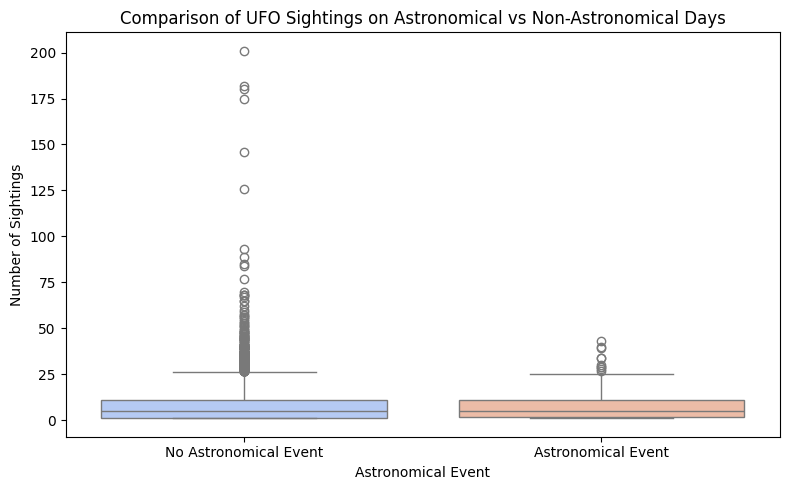

In [12]:
# Compare average sightings on event vs non-event days
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(data=daily_df, x='astro_event', y='sightings', palette='coolwarm')
plt.xticks([0, 1], ['No Astronomical Event', 'Astronomical Event'])
plt.title('Comparison of UFO Sightings on Astronomical vs Non-Astronomical Days')
plt.xlabel('Astronomical Event')
plt.ylabel('Number of Sightings')
plt.tight_layout()
plt.show()

In [13]:
# Optional: Print statistical summary
print("\nAverage sightings:")
print(daily_df.groupby('astro_event')['sightings'].describe())


Average sightings:
               count      mean       std  min  25%  50%   75%    max
astro_event                                                         
False        10248.0  7.591530  8.734619  1.0  1.0  5.0  11.0  201.0
True           239.0  7.698745  7.939453  1.0  1.5  5.0  11.0   43.0


## Time Lag Correlation
Do people report UFOs more 1 day before or after meteor showers?

In [14]:
# Create set of astronomical event dates and surrounding days
from datetime import timedelta

astro_days = set(astro_df['date'])
expanded_event_days = set()
for d in astro_days:
    for offset in [-1, 0, 1]:
        expanded_event_days.add(d + timedelta(days=offset))

# Tag each UFO sighting as within +/-1 day of an astronomical event
df['event_window'] = df['datetime'].dt.floor('d').isin(expanded_event_days)

# Aggregate daily sightings and event flag
daily_sightings = df.groupby(df['datetime'].dt.floor('d')).size().reset_index(name='sightings')
daily_sightings['event_window'] = daily_sightings['datetime'].isin(expanded_event_days)


<ipython-input-15-04e6cf7ed67e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=daily_sightings, x='event_window', y='sightings', palette='coolwarm')


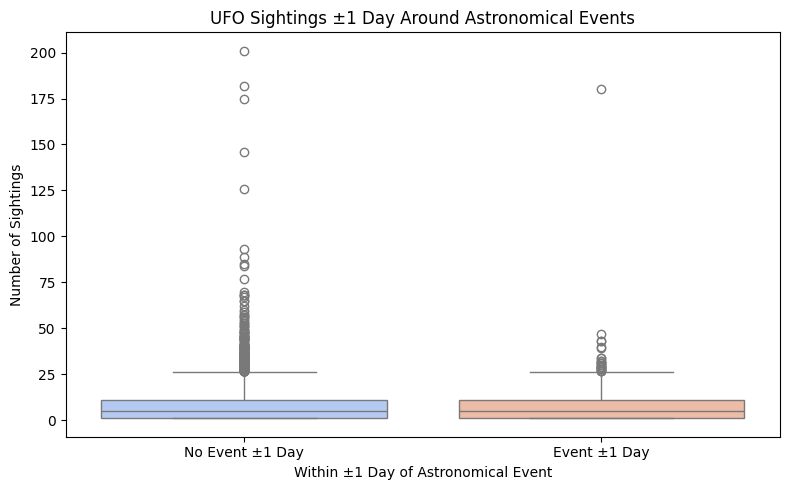

In [15]:
# Visualization: Boxplot of sightings +/- 1 day from events
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(data=daily_sightings, x='event_window', y='sightings', palette='coolwarm')
plt.xticks([0, 1], ['No Event ±1 Day', 'Event ±1 Day'])
plt.title('UFO Sightings ±1 Day Around Astronomical Events')
plt.xlabel('Within ±1 Day of Astronomical Event')
plt.ylabel('Number of Sightings')
plt.tight_layout()
plt.show()

In [16]:
# Statistical summary
print("\nAverage sightings within ±1 day of event vs other days:")
print(daily_sightings.groupby('event_window')['sightings'].describe())


Average sightings within ±1 day of event vs other days:
               count      mean       std  min  25%  50%   75%    max
event_window                                                        
False         9750.0  7.579487  8.617074  1.0  1.0  5.0  11.0  201.0
True           737.0  7.785617  9.949200  1.0  1.0  5.0  11.0  180.0
